# Wordle Twitter Scrape

Using [the Twitter API](https://developer.twitter.com/en/docs/twitter-api), this is an attempt to scrape the results that folks on Twitter share and save the results so they can be used in an analysis of performance. [Similar](https://towardsdatascience.com/three-million-wordle-tweets-later-3d3af23bd5c7) [analyses](https://www.instagram.com/p/CaFrbaTu0I9/) have certainly been done, but I have yet to find anyone that is continiously pulling data for Wordle results and/or making those results publicly available. Once this is setup, I'd like to have the scraper run on a daily basis and store the data in a Github repo in a similar way to how I've done my [Spotify genre map](https://github.com/ben-tanen/spotify-genre-map) or [YouTube caption](https://github.com/ben-tanen/yt-captions) projects.

In [139]:
from datetime import datetime, timedelta, timezone
import searchtweets
import requests
import time, sys, json, math
import pytz
import matplotlib.pyplot as plt
import numpy as np

In [2]:
st_creds = searchtweets.load_credentials("../data/twitter-data/twitter-api-creds.yaml")
bearer_token = st_creds['bearer_token']

Grabbing bearer token from OAUTH


In [43]:
# given two numbers a and b, where a <= b,
# report the proportion of a / b as a loading bar
# primarily for reporting the fill of a list with a known final size
def report_fill(a, b, width = 10, num_width = 3, clear = True):
    if clear:
        sys.stdout.write("\b" * (width + 2 + 4 + num_width * 2))
    else:
        sys.stdout.write("\n")
        sys.stdout.flush()

    fill = int(a / b * width)
    sys.stdout.write("[")
    sys.stdout.write("=" * fill)
    sys.stdout.write(" " * (width - fill))
    sys.stdout.write("] %s / %s" % (str(a).rjust(num_width), str(b).rjust(num_width)))
    sys.stdout.flush()

In [3]:
# given a puzzle number or a date,
# return information on the puzzle for that date
# including the range of which tweets should appear
def get_puzzle_details(puzzle = None, date = None):
    init_puzzle = 246
    init_date = datetime.strptime("2022-02-20 +0000", "%Y-%m-%d %z")
    if puzzle:
        new_puzzle = puzzle
        new_date = init_date + timedelta(days = new_puzzle - init_puzzle)
    elif date:
        new_date = datetime.strptime("%s +0000" % date, "%Y-%m-%d %z")
        new_puzzle = init_puzzle + (datetime.strptime("%s +0000" % date, "%Y-%m-%d %z") - init_date).days
    return {
        "date": new_date, 
        "time_range": {
            "start_time": new_date + timedelta(hours = -12),
            "end_time": new_date + timedelta(hours = 24 + 12)
        },
        "puzzle": new_puzzle
    }

In [22]:
# analyze the results from puzzle 244 (or the puzzle from two days ago)
details = get_puzzle_details(puzzle = 244,
                             date = (datetime.now() + timedelta(days = -2)).strftime("%Y-%m-%d")) # this is ignored
details

{'date': datetime.datetime(2022, 2, 18, 0, 0, tzinfo=datetime.timezone.utc),
 'time_range': {'start_time': datetime.datetime(2022, 2, 17, 12, 0, tzinfo=datetime.timezone.utc),
  'end_time': datetime.datetime(2022, 2, 19, 12, 0, tzinfo=datetime.timezone.utc)},
 'puzzle': 244}

In [23]:
# construct the url for the Twitter API call
query_puzzle = details['puzzle']
query_starttime = details['time_range']['start_time'].strftime("%Y-%m-%dT%H:%M:%S.000Z")
query_endtime = details['time_range']['end_time'].strftime("%Y-%m-%dT%H:%M:%S.000Z")

url_format = "https://api.twitter.com/2/tweets/search/recent?query=Wordle%20{puzzle}%20-is%3Aretweet%20-is%3Areply%20-is%3Aquote&start_time={starttime}&end_time={endtime}&max_results=100&sort_order={sort}&tweet.fields=id,created_at,text"
url = url_format.format(puzzle = query_puzzle, sort = "recency",
                        starttime = query_starttime, endtime = query_endtime)

In [46]:
# calculate the total allowed tweets per day
max_tweets_per_month = 2000000
max_tweets_per_day = int((max_tweets_per_month / 31) * 0.99)
max_tweets_per_day

63870

In [56]:
# pull the first set of results to start off building 
init_data_raw = requests.get(url, headers = {"Authorization": "Bearer %s" % bearer_token})
init_data_json = init_data_raw.json()
len(init_data_json['data'])

100

In [57]:
init_data_json['data'][:2]

[{'created_at': '2022-02-19T11:58:22.000Z',
  'id': '1495004833308368905',
  'text': 'Wordle 244 5/6\n\n⬜🟩⬜⬜⬜\n⬜🟩⬜⬜🟩\n⬜🟩⬜⬜🟩\n⬜🟩⬜⬜🟩\n🟩🟩🟩🟩🟩'},
 {'created_at': '2022-02-19T11:52:01.000Z',
  'id': '1495003234943053831',
  'text': 'Wordle 244 3/6\n\n🟩⬜🟨⬜⬜\n🟩⬜⬜⬜🟩\n🟩🟩🟩🟩🟩'}]

In [429]:
# clean the tweets as needed
def clean_tweets(tweets):
    return [{'created_at': pytz.utc.localize(datetime.strptime(tweet['created_at'], "%Y-%m-%dT%H:%M:%S.%fZ")),
             'id': tweet['id'],
             'text': re.sub(r'⬜', '⬛', 
                            re.sub(r'🟦|🟨', '🟨', 
                                   re.sub(r'🟧', '🟩', tweet['text']))).replace(u"\uFE0F", "")
            } for tweet in tweets]

# reverse some of the cleaning operations in order to save to .json
def unclean_tweets(tweets):
    return [{'created_at': tweet['created_at'].strftime("%Y-%m-%dT%H:%M:%S.%fZ"),
             'id': tweet['id'],
             'text': tweet['text']} for tweet in tweets]

clean_tweets(init_data_json['data'][:2])

[{'created_at': datetime.datetime(2022, 2, 19, 11, 58, 22, tzinfo=<UTC>),
  'id': '1495004833308368905',
  'text': 'Wordle 244 5/6\n\n⬛🟩⬛⬛⬛\n⬛🟩⬛⬛🟩\n⬛🟩⬛⬛🟩\n⬛🟩⬛⬛🟩\n🟩🟩🟩🟩🟩'},
 {'created_at': datetime.datetime(2022, 2, 19, 11, 52, 1, tzinfo=<UTC>),
  'id': '1495003234943053831',
  'text': 'Wordle 244 3/6\n\n🟩⬛🟨⬛⬛\n🟩⬛⬛⬛🟩\n🟩🟩🟩🟩🟩'}]

In [59]:
# query the rest of the results for one puzzle, pulling in up to the max allowable tweets per day
# this won't get everything, but we'll have to find a work around
tweets = clean_tweets(init_data_json['data'])
next_token = init_data_json['meta'].get('next_token')
while next_token and len(tweets) <= max_tweets_per_day:
    data_raw = requests.get(url + "&next_token=%s" % next_token, 
                            headers = {"Authorization": "Bearer %s" % bearer_token})
    data_json = data_raw.json()
    tweets += clean_tweets(data_json['data'])
    report_fill(len(tweets), max_tweets_per_day, width = 60, num_width = 5, clear = False)
    next_token = data_json['meta'].get('next_token')
    time.sleep(2.1)


[                                                            ]   199 / 63870
[                                                            ]   299 / 63870
[                                                            ]   398 / 63870
[                                                            ]   498 / 63870
[                                                            ]   595 / 63870
[                                                            ]   694 / 63870
[                                                            ]   793 / 63870
[                                                            ]   893 / 63870
[                                                            ]   993 / 63870
[=                                                           ]  1092 / 63870
[=                                                           ]  1192 / 63870
[=                                                           ]  1292 / 63870
[=                                                           ]  1392 / 6387

[====================                                        ] 21306 / 63870
[====================                                        ] 21406 / 63870
[====================                                        ] 21505 / 63870
[====================                                        ] 21604 / 63870
[====================                                        ] 21704 / 63870
[====================                                        ] 21802 / 63870
[====================                                        ] 21902 / 63870
[====================                                        ] 22002 / 63870
[====================                                        ] 22102 / 63870
[====================                                        ] 22202 / 63870
[====================                                        ] 22302 / 63870
[=====================                                       ] 22400 / 63870
[=====================                                       ] 22500 / 63870

[=======================================                     ] 42385 / 63870
[=======================================                     ] 42485 / 63870
[========================================                    ] 42585 / 63870
[========================================                    ] 42685 / 63870
[========================================                    ] 42785 / 63870
[========================================                    ] 42885 / 63870
[========================================                    ] 42985 / 63870
[========================================                    ] 43085 / 63870
[========================================                    ] 43185 / 63870
[========================================                    ] 43285 / 63870
[========================================                    ] 43385 / 63870
[========================================                    ] 43484 / 63870
[========================================                    ] 43584 / 63870

[=========================================================== ] 63461 / 63870
[=========================================================== ] 63561 / 63870
[=========================================================== ] 63661 / 63870
[=========================================================== ] 63761 / 63870
[=========================================================== ] 63861 / 63870
[============================================================] 63961 / 63870

I previously ran the above code but didn't set a maximum number of tweets in order to get a full survey of the data for day's worth of tweets and I'll use that as a point of comparison for the sample we just pulled.

In [68]:
all_tweets = clean_tweets(json.load(open('../data/twitter-data/all-tweets_wordle-244_20220221.json')))
len(all_tweets)

238611

In [153]:
def plot_tweet_distribution(tweets, details, subtitle = None, bins = None):
    # pull out time for each tweet
    times = [tweet['created_at'] for tweet in tweets]
    times.sort()
    
    # calculate as timedeltas from 0000 UTC
    dt_hours = [(time - details['date']).total_seconds() / (60 * 60) for time in times]
    
    # define axis values
    axis_nums = [x for x in range(-12, 36, 2)]
    axis_labels = map(lambda x: str(x), axis_nums)

    # define labels + title
    xlabel = "Hours offset from {date} 00:00 UTC".format(date = details['date'].strftime("%Y-%m-%d"))
    title_format = "Time distribution of {n_tweets} tweets containing 'Wordle {puzzle}' between {t0} and {t1}"
    if subtitle:
        title_format += "\n%s" % subtitle
    title = title_format.format(n_tweets = len(tweets), puzzle = details['puzzle'],
                                t0 = details['time_range']['start_time'].strftime("%Y-%m-%d %H:%M UTC"),
                                t1 = details['time_range']['end_time'].strftime("%Y-%m-%d %H:%M UTC"))
    
    # make the plot
    plt.figure(figsize = (14, 5))
    plt.xticks(axis_nums, axis_labels)
    plt.xlim(-12, 36)
    plt.xlabel(xlabel)
    plt.hist(dt_hours, bins = bins if bins else math.ceil((times[-1] - times[0]).total_seconds() / (60 * 60)))
    plt.title(title)
    plt.show()

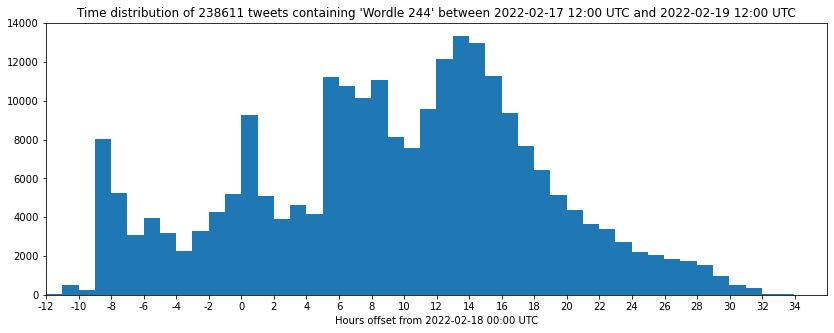

In [154]:
plot_tweet_distribution(all_tweets, details)

In [148]:
# calculate the share of tweets that occurred between 6:00 UTC and 18:00 UTC (12AM ET and 12PM ET)
dt_hours = [(tweet['created_at'] - details['date']).total_seconds() / (60 * 60) for tweet in all_tweets]
len([t for t in dt_hours if t >= 6 and t <= 18]) / len(dt_hours)

0.519628181433379

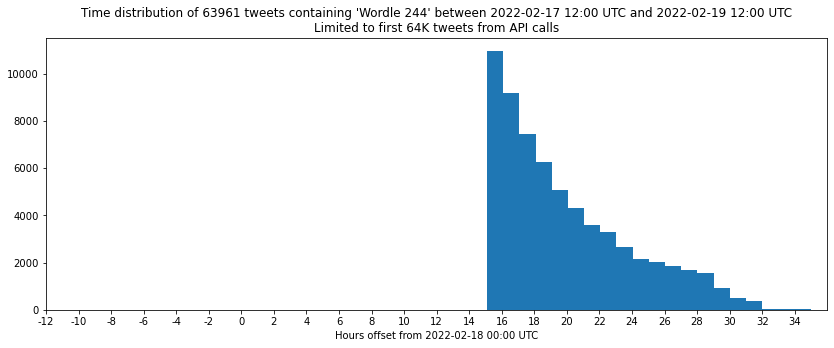

In [149]:
plot_tweet_distribution(tweets, details, subtitle = "Limited to first 64K tweets from API calls")

In [273]:
# throw all of the querying code into a function for easier use later
def query_wordle_tweets(details, 
                        next_token = None,
                        sort = "recency",
                        max_tweets = max_tweets_per_day,
                        loud = True):
    # construct the url for the Twitter API call
    query_puzzle = details['puzzle']
    query_starttime = details['time_range']['start_time'].strftime("%Y-%m-%dT%H:%M:%S.%fZ")
    query_endtime = details['time_range']['end_time'].strftime("%Y-%m-%dT%H:%M:%S.%fZ")

    url_format = "https://api.twitter.com/2/tweets/search/recent?"
    url_format += "query=Wordle%20{puzzle}%20-is%3Aretweet%20-is%3Areply%20-is%3Aquote"
    url_format += "&start_time={starttime}&end_time={endtime}"
    url_format += "&max_results={tweets_per_pull}&sort_order={sort}&tweet.fields=id,created_at,text"
    url = url_format.format(puzzle = query_puzzle, sort = sort, 
                            tweets_per_pull = max(10, min(100, max_tweets)),
                            starttime = query_starttime, endtime = query_endtime)
    
    init_data_raw = requests.get(url + ("&next_token=%s" % next_token if next_token else ""), 
                                 headers = {"Authorization": "Bearer %s" % bearer_token})
    init_data_json = init_data_raw.json()
    
    if init_data_raw.status_code != 200:
        print(init_data_json)
    elif 'data' not in init_data_json.keys():
        print(init_data_json)

    tweets = clean_tweets(init_data_json['data'])
    next_token = init_data_json['meta'].get('next_token')
    time.sleep(2.1)
    while next_token and len(tweets) < max_tweets:
        data_raw = requests.get(url + "&next_token=%s" % next_token, 
                                headers = {"Authorization": "Bearer %s" % bearer_token})
        data_json = data_raw.json()
        
        if data_raw.status_code != 200:
            print(data_json)
        elif 'data' not in data_json.keys():
            print(data_json)
        
        tweets += clean_tweets(data_json['data'])
        if loud:
            report_fill(len(tweets), max_tweets, width = 60, num_width = 5, clear = False)
        next_token = data_json['meta'].get('next_token')
        time.sleep(2.1)
        
    return [tweets, next_token]


[                                                            ]   200 / 63870
[                                                            ]   299 / 63870
[                                                            ]   398 / 63870

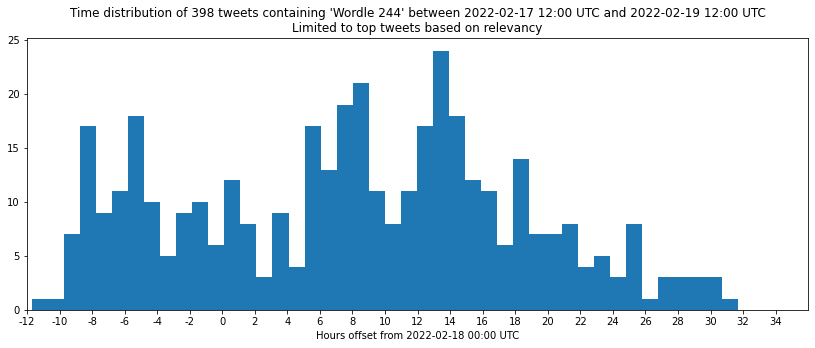

In [217]:
[relevant_tweets, next_token] = query_wordle_tweets(details, sort = "relevancy")
plot_tweet_distribution(relevant_tweets, details, subtitle = "Limited to top tweets based on relevancy")

In [218]:
# create array of array of 30-min time ranges
tr = details['time_range']

trs_init = [tr['start_time'] + timedelta(minutes = dt) for dt in 
            range(0, int((tr['end_time'] - tr['start_time']).total_seconds() / 60) + 1, 30)]

trs = [{'start_time': t,
        'end_time': t + timedelta(minutes = 30, milliseconds = -1),
        'next_token': None,
        'tweets': 0
       } for t in trs_init]

trs[:2]

[{'start_time': datetime.datetime(2022, 2, 17, 12, 0, tzinfo=datetime.timezone.utc),
  'end_time': datetime.datetime(2022, 2, 17, 12, 29, 59, 999000, tzinfo=datetime.timezone.utc),
  'next_token': None,
  'tweets': 0},
 {'start_time': datetime.datetime(2022, 2, 17, 12, 30, tzinfo=datetime.timezone.utc),
  'end_time': datetime.datetime(2022, 2, 17, 12, 59, 59, 999000, tzinfo=datetime.timezone.utc),
  'next_token': None,
  'tweets': 0}]

In [219]:
# survey across these defined 30-min time ranges cross-sectionally until we hit the max_tweets_per_day
tweets_survey = [ ]

while len(tweets_survey) < max_tweets_per_day:
    print("taking another pass")
    for ix, tr in enumerate(trs):
        [survey, next_token] = query_wordle_tweets({'puzzle': details['puzzle'], 'time_range': tr},
                                                   next_token = tr['next_token'],
                                                   max_tweets = 100,
                                                   loud = False)
        tweets_survey += survey
        trs[ix]['next_token'] = next_token
        trs[ix]['tweets'] += len(survey)
        report_fill(len(tweets_survey), max_tweets_per_day, width = 60, num_width = 5, clear = False)
        if len(tweets_survey) > max_tweets_per_day:
            break

taking another pass

[                                                            ]    17 / 63870
[                                                            ]    24 / 63870
[                                                            ]   124 / 63870
[                                                            ]   224 / 63870
[                                                            ]   377 / 63870
[                                                            ]   450 / 63870
[                                                            ]   646 / 63870
[                                                            ]   746 / 63870
[                                                            ]   944 / 63870
[                                                            ]  1044 / 63870
[=                                                           ]  1241 / 63870
[=                                                           ]  1341 / 63870
[=                                                     

[=========================                                   ] 27633 / 63870
[==========================                                  ] 27733 / 63870
[==========================                                  ] 27833 / 63870
[==========================                                  ] 28030 / 63870
[==========================                                  ] 28130 / 63870
[==========================                                  ] 28327 / 63870
[==========================                                  ] 28525 / 63870
[==========================                                  ] 28722 / 63870
[===========================                                 ] 28920 / 63870
[===========================                                 ] 29020 / 63870
[===========================                                 ] 29217 / 63870
[===========================                                 ] 29317 / 63870
[===========================                                 ] 29514 / 63870

[====================================================        ] 56301 / 63870
[====================================================        ] 56401 / 63870
[=====================================================       ] 56501 / 63870
[=====================================================       ] 56700 / 63870
[=====================================================       ] 56800 / 63870
[=====================================================       ] 56998 / 63870
[=====================================================       ] 57098 / 63870
[=====================================================       ] 57198 / 63870
[=====================================================       ] 57298 / 63870
[=====================================================       ] 57398 / 63870
[======================================================      ] 57498 / 63870
[======================================================      ] 57696 / 63870
[======================================================      ] 57796 / 63870

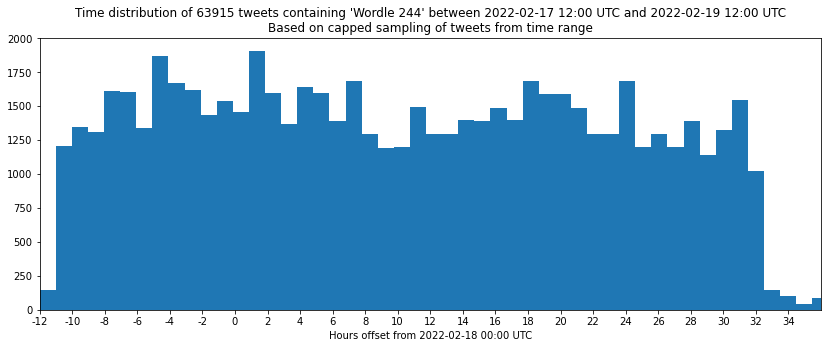

In [220]:
plot_tweet_distribution(tweets_survey, details, subtitle = "Based on capped sampling of tweets from time range")

lets do one slightly better and accomodate for the distribution we saw in the full data so that we randomly sample close to that distribution.

In [232]:
# calculate share of tweets that occur during any given 30-minute time range
for ix, tr in enumerate(trs):
    tweets_in_range = [tweet for tweet in all_tweets 
                       if tweet['created_at'] >= tr['start_time'] and tweet['created_at'] <= tr['end_time']]
    trs[ix]['probability'] = len(tweets_in_range) / len(all_tweets)

In [256]:
[math.ceil(tr['probability'] * max_tweets_per_day) for tr in trs[:2]]

[5, 2]

In [289]:
def query_wordle_tweets_v2(details,
                           sort = "recency",
                           min_per_tr = 30,
                           max_tweets = max_tweets_per_day,
                           probability_scale = False,
                           loud = True):
    
    # create array of array of 30-min time ranges
    tr = details['time_range']
    trs_init = [tr['start_time'] + timedelta(minutes = dt) for dt in 
                range(0, int((tr['end_time'] - tr['start_time']).total_seconds() / 60) + 1, min_per_tr)]
    trs = [{'start_time': t,
            'end_time': t + timedelta(minutes = min_per_tr, milliseconds = -1)} for t in trs_init]
    trs = [{'start_time': t['start_time'],
            'end_time': t['end_time'],
            'next_token': None,
            'tweets': 0,
            'probability': len([tweet for tweet in all_tweets \
                                if tweet['created_at'] >= t['start_time'] \
                                and tweet['created_at'] <= t['end_time']]) / \
                           len(all_tweets)} for t in trs]
    
    tweets = [ ]

    while len(tweets) < max_tweets:
        max_tweets_remaining = max_tweets - len(tweets)
        for ix, tr in enumerate(trs):
            max_tweets_ix = math.ceil(tr['probability'] * max_tweets_remaining * 0.9) if probability_scale else 100
            [survey, next_token] = query_wordle_tweets({'puzzle': details['puzzle'], 'time_range': tr},
                                                       next_token = tr['next_token'],
                                                       max_tweets = max_tweets_ix,
                                                       loud = False)
            tweets += survey
            trs[ix]['next_token'] = next_token
            trs[ix]['tweets'] += len(survey)
            if loud:
                report_fill(len(tweets), max_tweets, width = 60, num_width = 5, clear = False)
            if len(tweets) > max_tweets:
                break
                
    return [tweets, trs]                     

In [281]:
[tweets_v2, trs_v2] = query_wordle_tweets_v2(details, probability_scale = True)


[                                                            ]    10 / 63870
[                                                            ]    17 / 63870
[                                                            ]    99 / 63870
[                                                            ]   143 / 63870
[                                                            ]   215 / 63870
[                                                            ]   250 / 63870
[=                                                           ]  1434 / 63870
[==                                                          ]  2226 / 63870
[==                                                          ]  3016 / 63870
[===                                                         ]  3509 / 63870
[===                                                         ]  4002 / 63870
[====                                                        ]  4398 / 63870
[====                                                        ]  4695 / 6387

[==========================================================  ] 61902 / 63870
[==========================================================  ] 61918 / 63870
[==========================================================  ] 61929 / 63870
[==========================================================  ] 61939 / 63870
[==========================================================  ] 61964 / 63870
[==========================================================  ] 61980 / 63870
[==========================================================  ] 62001 / 63870
[==========================================================  ] 62012 / 63870
[==========================================================  ] 62022 / 63870
[==========================================================  ] 62037 / 63870
[==========================================================  ] 62051 / 63870
[==========================================================  ] 62070 / 63870
[==========================================================  ] 62088 / 63870

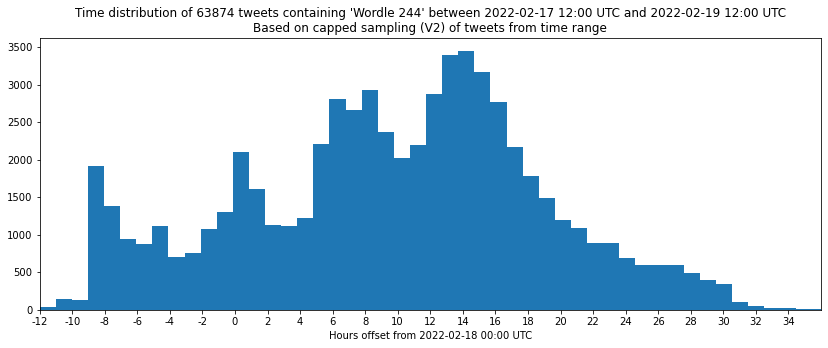

In [282]:
plot_tweet_distribution(tweets_v2, details, subtitle = "Based on capped sampling (V2) of tweets from time range")

In [313]:
with open('../data/twitter-data/sampled-tweets_wordle-244_20220221.json', 'w', encoding = 'utf-8') as f:
    json.dump(unclean_tweets(tweets_v2), f, ensure_ascii = False, indent = 4)

In [430]:
sampled_tweets = clean_tweets(json.load(open('../data/twitter-data/sampled-tweets_wordle-244_20220221.json')))
len(sampled_tweets)

63874

## data checks

1. does the tweet contain some combination of 🟩/⬛/⬜/🟨 in sequences of 5?
2. does the number of sequences match up with the reported X/6 score?
3. does the tweet include anything about "cheat" or "cheating"? are there other keywords that we might want to exclude

perform all of these data checks as functions in a list (more flexible if i want to add/adjust functions later)

In [356]:
sampled_tweets[:6]

[{'created_at': datetime.datetime(2022, 2, 17, 12, 29, 53, tzinfo=<UTC>),
  'id': '1494287986967867392',
  'text': 'Wordle 244 5/6\n\n⬛⬛⬛🟨🟩\n🟩⬛⬛⬛🟩\n🟩⬛⬛⬛🟩\n🟩🟩⬛⬛🟩\n🟩🟩🟩🟩🟩\nTricky'},
 {'created_at': datetime.datetime(2022, 2, 17, 12, 27, 21, tzinfo=<UTC>),
  'id': '1494287350012465153',
  'text': '*SPOILER*\n\nWordle 244 5/6\n\n⬛⬛⬛⬛🟩\n⬛⬛⬛⬛🟩\n⬛⬛🟨⬛🟩\n⬛🟩⬛🟩🟩\n🟩🟩🟩🟩🟩\n\nWHATS WITH ALL THE DOUBLES RECENTLY'},
 {'created_at': datetime.datetime(2022, 2, 17, 12, 24, 13, tzinfo=<UTC>),
  'id': '1494286561214562309',
  'text': 'Wordle 244 4/6\n\n⬛⬛⬛⬛🟨\n⬛⬛🟨⬛🟩\n⬛🟩⬛⬛🟩\n🟩🟩🟩🟩🟩'},
 {'created_at': datetime.datetime(2022, 2, 17, 12, 22, 25, tzinfo=<UTC>),
  'id': '1494286109773340672',
  'text': 'Wordle 244 X/6\n\n⬛⬛⬛⬛🟩\n⬛⬛🟩⬛⬛\n🟨⬛🟨⬛⬛\n⬛🟩🟩🟩🟩\n⬛🟩🟩🟩🟩\n⬛🟩🟩🟩🟩\n#DailyWordleClub\n\nBastard'},
 {'created_at': datetime.datetime(2022, 2, 17, 12, 17, 7, tzinfo=<UTC>),
  'id': '1494284774701412356',
  'text': 'Wordle 244 6/6\n\nthis gave me a headache\n\n⬛⬛⬛⬛🟩\n🟨⬛⬛⬛🟩\n⬛⬛🟨⬛🟩\n⬛🟩⬛⬛🟩\n⬛🟩⬛⬛🟩\n🟩🟩🟩🟩🟩 https://t.co/cb6seLMyKg'},

In [431]:
import re

In [432]:
len(re.findall(r'(🟩|⬛|🟨){5}', sampled_tweets[6]['text']))

3

In [433]:
t = sampled_tweets[1]
rms = re.match(r'Wordle {puzzle} ([1-6]|X)/6'.format(puzzle = details['puzzle']), t['text'])
if rms:
    print(int((rms.groups())[0]))

In [456]:
seq_regex = r'(🟩|⬛|🟨){5}'

def get_score(text):
    rms = re.findall(r'ordle {puzzle} ([1-6]|X)/6'.format(puzzle = details['puzzle']), text)
    if len(rms) > 0:
        rm = rms[0]
        if rm == "X":
            return rm
        else:
            return int(rms[0])
    else:
        None

filter_fxns = [
    # check that the tweet actually contains results sequence
    (lambda t: bool(re.search(seq_regex, t))), 
    
    # check if tweet contains any sketchy keywords
    # (lambda t: not bool(re.search(r'(cheat)', t.lower()))),
    
    # check if reported score matches N results sequences
    (lambda t: len(re.findall(seq_regex, t)) == 6 if get_score(t) == "X" \
               else len(re.findall(seq_regex, t)) == get_score(t))
]

In [457]:
filtered_tweets = [tweet for tweet in sampled_tweets if all(list(map((lambda d: d(tweet['text'])), filter_fxns)))]
n_filtered_out_tweets = len(sampled_tweets) - len(filtered_tweets)
print("%d tweets filtered out (%f pct); %d tweets remain" % (n_filtered_out_tweets, 
                                                             n_filtered_out_tweets / len(sampled_tweets) * 100,
                                                             len(filtered_tweets)))

1966 tweets filtered out (3.077935 pct); 61908 tweets remain


In [458]:
with open('../data/twitter-data/filtered-tweets_wordle-244_20220221.json', 'w', encoding = 'utf-8') as f:
    json.dump(unclean_tweets(filtered_tweets), f, ensure_ascii = False, indent = 4)